In [1]:
# Import the file
#Import Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
df = pd.read_csv('Solar.csv')
df

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21040,USAFA,20180928,1530,38.95,-104.83,1947,2.018090e+11,9,15,Fall,11.66992,43.22510,9.79611,14,10.0,802.3,722
21041,USAFA,20180929,1300,38.95,-104.83,1947,2.018090e+11,9,13,Fall,18.22510,28.98247,10.88992,13,10.0,799.2,722
21042,USAFA,20180929,1400,38.95,-104.83,1947,2.018090e+11,9,14,Fall,15.52124,33.49167,8.24479,10,10.0,798.4,722
21043,USAFA,20180929,1500,38.95,-104.83,1947,2.018090e+11,9,15,Fall,6.63452,51.62163,12.47328,10,10.0,797.8,722


In [1]:
!pip install skopt
!pip install scikit-optimize

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.8 MB/s eta 0:00:00


In [5]:
import skopt

<ipython-input-10-82fe3e3705fa>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()


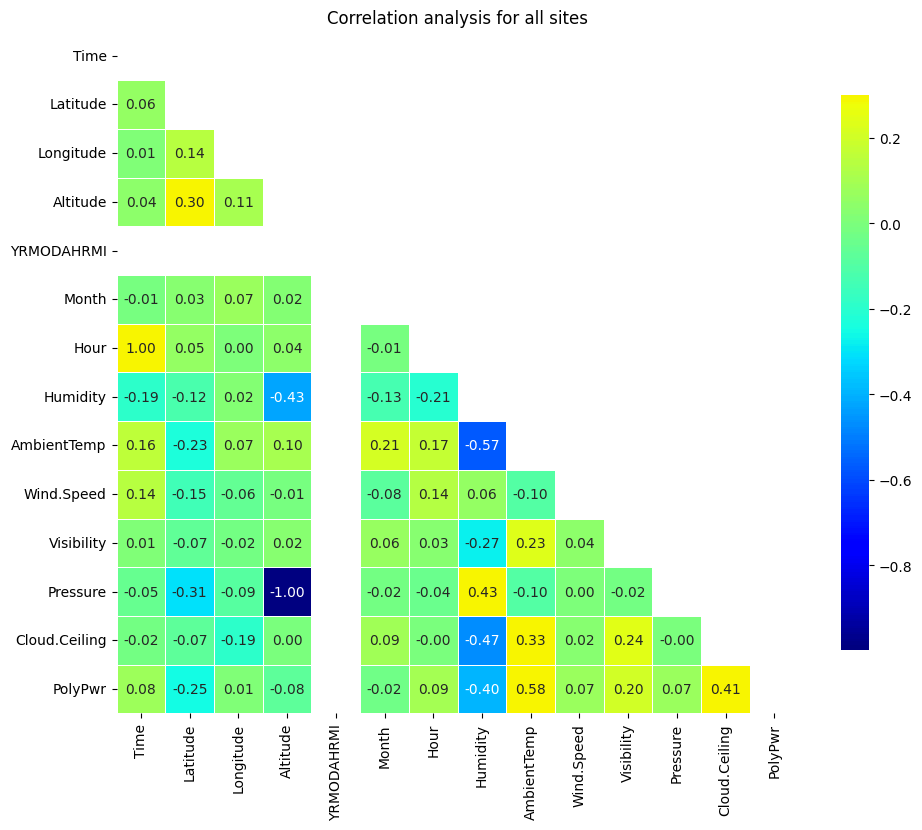

In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
df_corr = df[['Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_corr, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis for all sites');

In [11]:
# Encode location data
df_with_location_en = pd.get_dummies(df, columns=['Location'], drop_first=True)
# Encode season data
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

In [12]:
min_hour_of_interest = 10
max_hour_of_interest = 15

In [13]:
df_with_loc_season_en['delta_hr']= df_with_loc_season_en.Hour - min_hour_of_interest

In [15]:
# Create Cyclic date features
df_with_loc_season_en['sine_mon']= np.sin((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['cos_mon']= np.cos((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['sine_hr']= np.sin((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr']= np.cos((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))

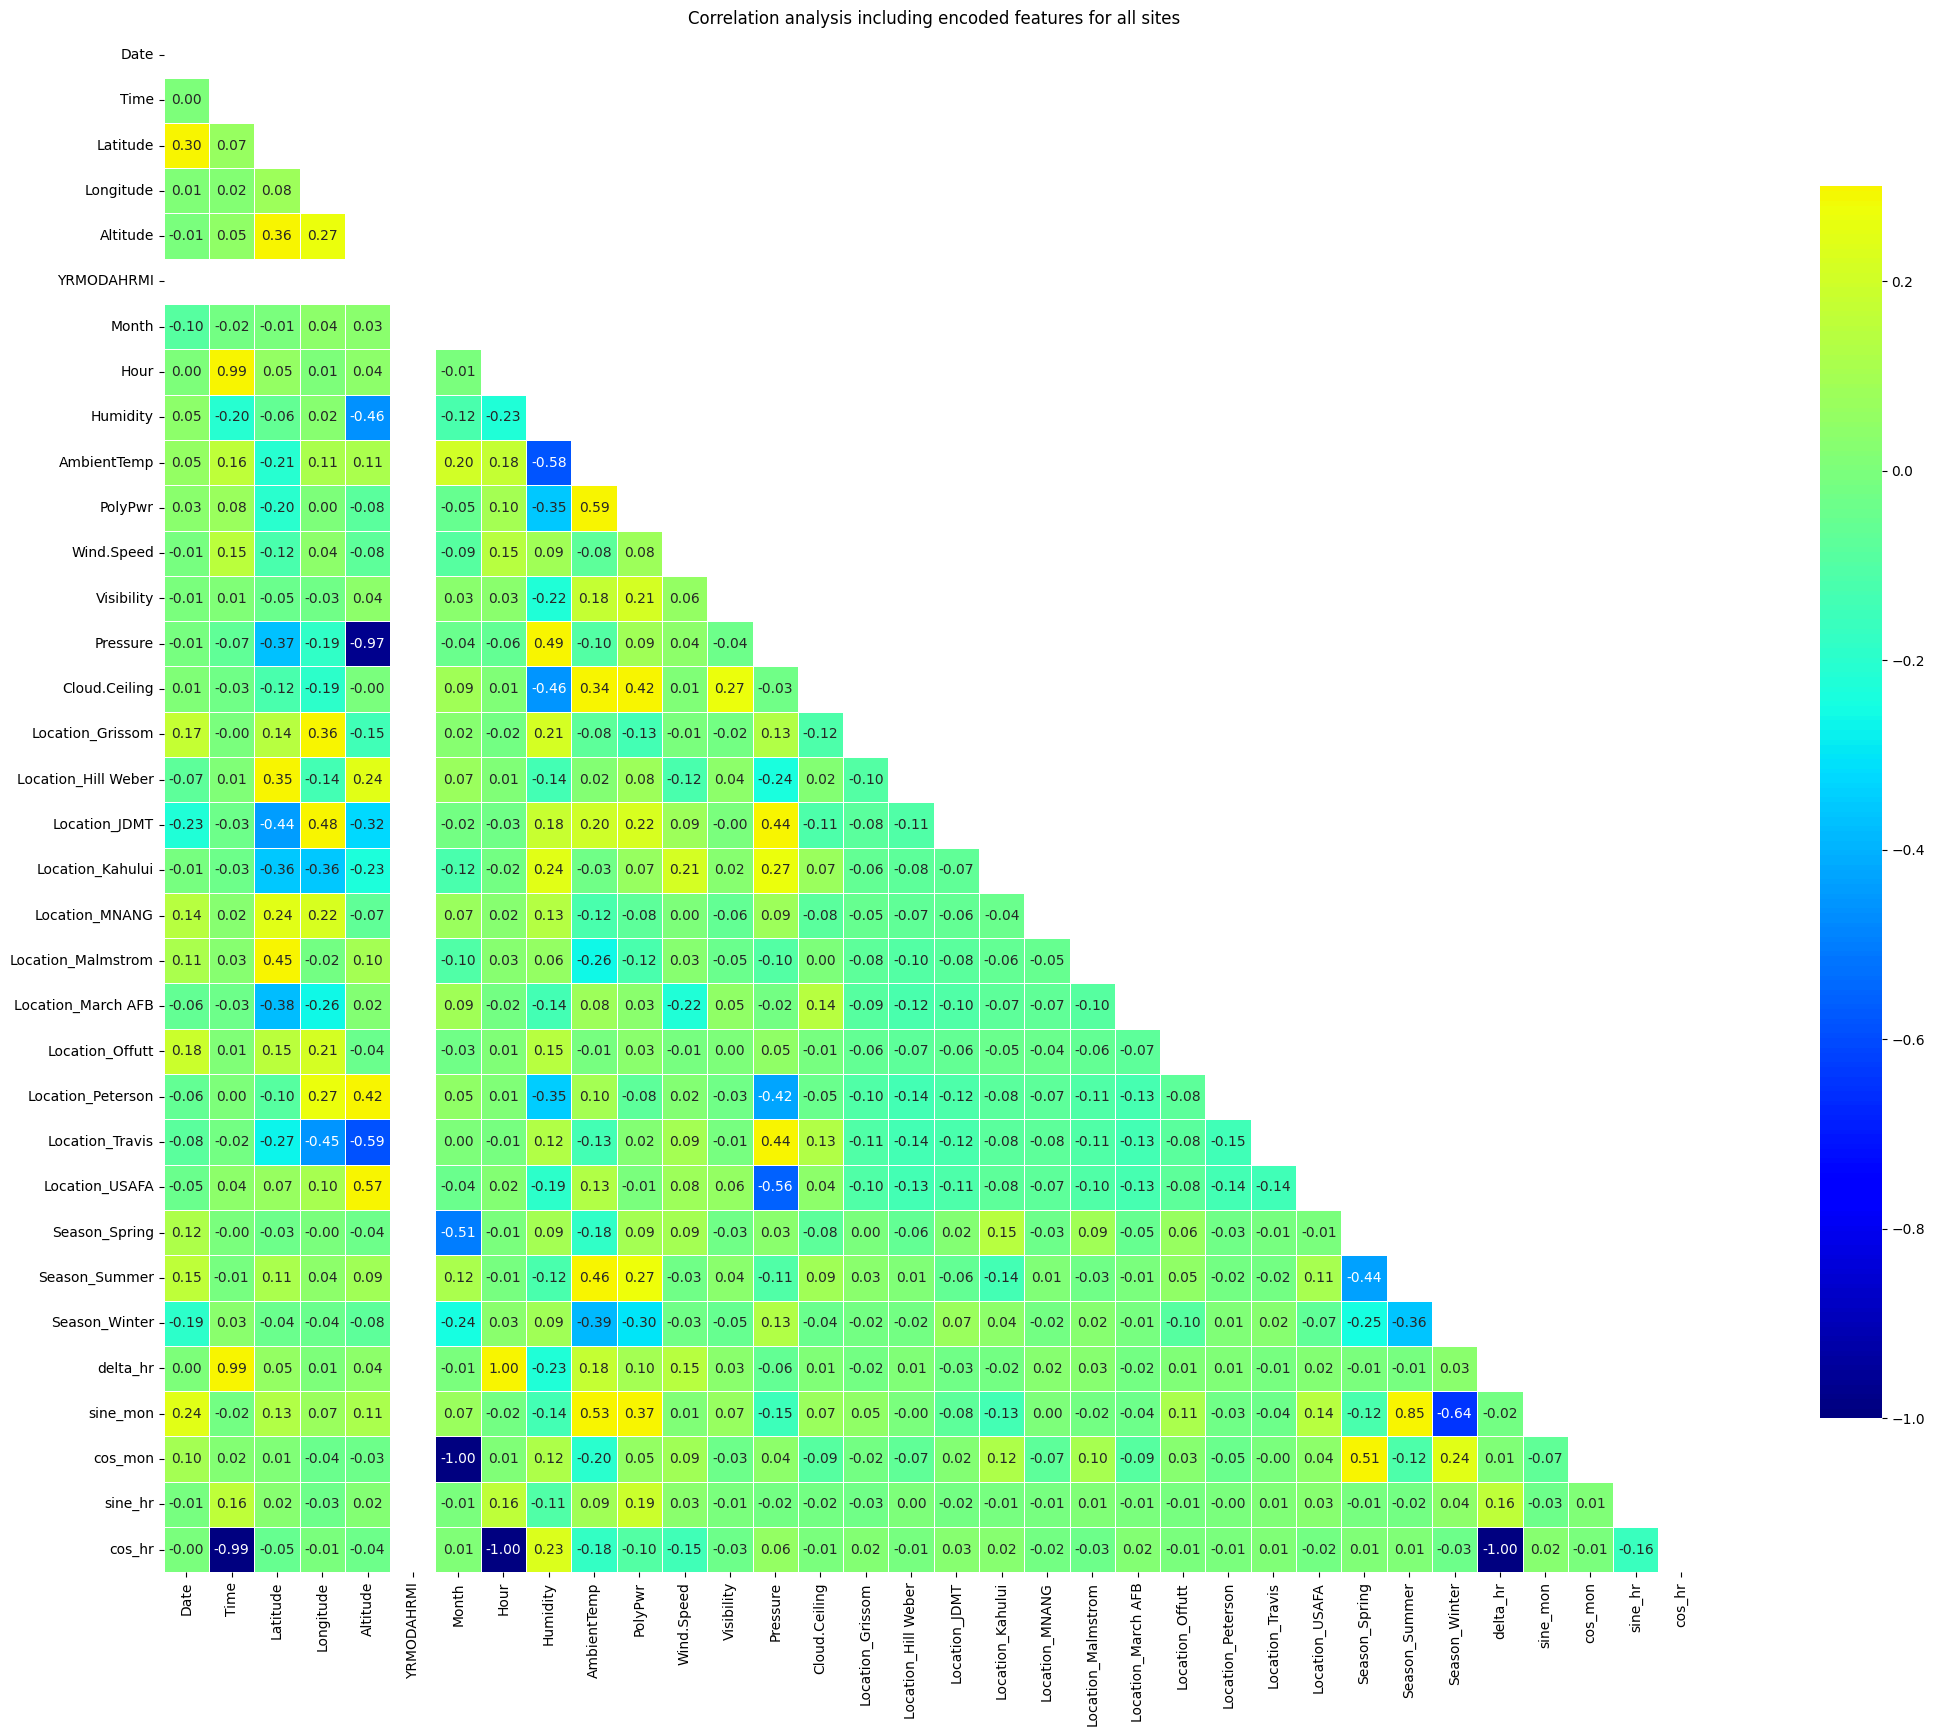

In [16]:
mask2 = np.triu(np.ones_like(df_with_loc_season_en.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df_with_loc_season_en.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis including encoded features for all sites');

In [17]:
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

df_processed = df_with_loc_season_en[selected_columns].reset_index(drop=True)
target_label = 'PolyPwr'
input_feat = list(set(selected_columns).difference(set([target_label])))
df_X = df_processed[input_feat].reset_index(drop=True)
df_y = df_processed[target_label]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [18]:
# Create list of each hyper-param to tune
n_estimators_list = [int(50*x) for x in range(2, 30)]

learning_rate_list = [round(x/500, 4) for x in range(2, 25)]

max_depth_list = [int(x) for x in range(3, 13)]
max_depth_list.append(-1)

n_leaves_list = [int(50*x) for x in range(2, 30)]

feature_fraction_list = [x/10 for x in range(1, 10)]

objective_list = ['rmse', 'mae', 'mape']

In [19]:
# Structure model hyper-params as a dictionary
lgbm_grid = {'num_leaves':n_leaves_list,
             'max_depth':max_depth_list,
             'learning_rate':learning_rate_list,
             'n_estimators':n_estimators_list,
             'feature_fraction':feature_fraction_list,
             'objective':objective_list}

In [20]:
# Create base LGBM model
lgbm_base = LGBMRegressor()

In [21]:
# Create random search for LGBM model
lgbm_random = RandomizedSearchCV(estimator=lgbm_base, param_distributions=lgbm_grid,
                                 n_iter=1000, cv=4, verbose=2, random_state=42,
                                 n_jobs=-1)

In [ ]:
%%time
# Fit the random search LGBM model
lgbm_random.fit(X_train, y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


In [ ]:
lgbm_random.fit(X_train, y_train)
# Get score of best model during hyper-param tuning
lgbm_random.best_score_

In [ ]:
mean_score = lgbm_random.cv_results_['mean_test_score']
std_score = lgbm_random.cv_results_['std_test_score']
params = lgbm_random.cv_results_['params']

In [ ]:
cv_score_df = pd.DataFrame(params)
cv_score_df['mean_score'] = mean_score
cv_score_df['std_score'] = std_score

In [ ]:
# Random
lgbm_model = LGBMRegressor(objective='rmse', num_leaves=900, n_estimators=1400, max_depth=11, learning_rate=0.008)

In [ ]:
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
# Explained variance
explained_variance_score(y_test.ravel(), y_pred)
# R2 score
r2_score(y_test.ravel(), y_pred)
# Mean absolute error
mean_absolute_error(y_test.ravel(), y_pred)
# Root mean square error
np.sqrt(mean_squared_error(y_test.ravel(), y_pred))
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

In [ ]:
y_all_pred = lgbm_model.predict(df_X.values)
r2_score(df_y.values, y_all_pred)

In [ ]:
# Calculate scaled feature importance as a percentage
feat_imp_score = (lgbm_model.feature_importances_/max(lgbm_model.feature_importances_)*100).tolist()
feature_ranking_with_score = dict(sorted(zip(feat_imp_score, input_feat), reverse=True))
feature_ranking_with_score
feat_ranking_list = list(feature_ranking_with_score.values())
np.array(feat_ranking_list)